In [1]:
# =============================================================================
# Environment Setup and GPU Configuration
# =============================================================================
import tensorflow as tf
from functions import *
from ppg_functions import *
tf.random.set_seed(42)
np.random.seed(42)

mask_unused_gpus()

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

2025-08-08 16:47:21.027084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754664441.039688  532058 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754664441.043255  532058 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-08 16:47:21.055298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Set the following GPU(s) to be visible: 1
Tensorflow session initialized


I0000 00:00:1754664458.518627  532058 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:36:00.0, compute capability: 8.6


In [2]:
# Import necessary libraries
import scipy.io as sio
import numpy as np

# Load the .mat file containing Wrist PPG data
mat_data = sio.loadmat('../Datasets/WristPPG/wristPPG.mat')

# Sampling frequency of the signals
fs = 256

# Initialize lists to store processed signals and their corresponding categories
X = []
condition = []

# Iterate through each signal in the dataset
for i in range(mat_data['signals'][0].shape[0]):
    # Extract the signal data for the current patient
    data = mat_data['signals'][0][i]
    patient_ppg = mat_data['signals'][0][i].tolist()[0]
    
    # Extract the category/class of the current patient
    patient_category = mat_data['condition_class'][0][i]
    
    # Crop the beginning and end of each signal to remove noise or artifacts
    patient_ppg = patient_ppg[fs * 30 : -fs * 30]
    
    # Append the processed signal and its category to the respective lists
    X.append(patient_ppg)
    condition.append(patient_category)

# Create a dictionary to map each unique string category to a unique integer
condition_mapping = {'low_resistance_bike': 0, 'high_resistance_bike': 1, 'walk': 2, 'run': 3}

# Extract the list of labels (keys of the mapping dictionary)
labels = list(condition_mapping.keys())

# Assign the condition list to the variable `y` for consistency with other cells
y = condition

# Print the labels for verification
print(labels)


['low_resistance_bike', 'high_resistance_bike', 'walk', 'run']


In [3]:
from ppg_functions import *

desired_fs = 100
nfft = 1024
fs = 256
ff = [0.01,desired_fs/2-1]
ff = [0.67, 8]
X_f, spectrums, residuals = prepare_data(X, y, fs, desired_fs,ff, nfft,apply_moving_average=False)
w = desired_fs*6
o = (desired_fs*2)
val_p = 0
ts_p = 0

100%|██████████| 19/19 [00:00<00:00, 86.66it/s]


In [4]:
# Section: Verify NaNs in Signal Data

# Iterate through each signal in the dataset to check for NaN values
for patient_index in range(len(X)):
    # Count the number of NaN values in the current signal
    nans_count = np.count_nonzero(np.isnan(X[patient_index]))
    print(f'Patient: {patient_index}, NaNs: {nans_count}')


Patient: 0, NaNs: 0
Patient: 1, NaNs: 0
Patient: 2, NaNs: 0
Patient: 3, NaNs: 0
Patient: 4, NaNs: 0
Patient: 5, NaNs: 0
Patient: 6, NaNs: 0
Patient: 7, NaNs: 0
Patient: 8, NaNs: 0
Patient: 9, NaNs: 0
Patient: 10, NaNs: 0
Patient: 11, NaNs: 0
Patient: 12, NaNs: 0
Patient: 13, NaNs: 0
Patient: 14, NaNs: 0
Patient: 15, NaNs: 0
Patient: 16, NaNs: 0
Patient: 17, NaNs: 0
Patient: 18, NaNs: 0


In [5]:
# Section: Analyze Distribution of Conditions in Dataset

from collections import Counter

# Count occurrences of each condition in the dataset and print the result
# `y` contains the list of conditions for each signal, and `Counter` provides a frequency count
print(Counter(y))

Counter({np.int64(2): 6, np.int64(0): 5, np.int64(3): 5, np.int64(1): 3})


In [6]:
import numpy as np
from sklearn.metrics import davies_bouldin_score
from sklearn.utils import resample
from functions import *
from ppg_functions import *

# ===========================================================
# Autoencoder Training and DBI Evaluation Utilities
# ===========================================================

def compute_dbi(embeddings, y):
    """
    Compute the Davies–Bouldin Index (DBI) for given embeddings and labels.

    Parameters
    ----------
    embeddings : np.ndarray
        Embedding vectors for each sample.
    y : array-like
        Class labels for each sample.

    Returns
    -------
    float
        Davies–Bouldin Index value. Returns np.nan if less than two unique classes.
    """
    unique = np.unique(y)
    if len(unique) < 2:
        return np.nan
    return davies_bouldin_score(embeddings, y)

def compute_dbi_subsets(embeddings, y):
    """
    Compute DBI for three activity subsets and for all classes.

    Subsets:
        1) Low vs High Resistance Bike
        2) Walk vs Run
        3) Bike Activity (both bikes) vs Stand Activity (walk+run)

    Parameters
    ----------
    embeddings : np.ndarray
        Embedding vectors for each sample.
    y : array-like
        Class labels for each sample.

    Returns
    -------
    dict
        DBI scores for each subset and for all classes.
    """
    # Mapping from activity names to label indices
    mapping = {
        'Low Resistance Bike': 0,
        'High Resistance Bike': 1,
        'Walk': 2,
        'Run': 3
    }
    subsets = [
        (['Low Resistance Bike', 'High Resistance Bike'], 1),
        (['Walk', 'Run'], 2),
        (['Bike Activity', 'Stand Activity'], 3),
    ]
    scores = {}
    for names, idx in subsets:
        combined_idxs = []
        y_sub = []
        for name in names:
            if name == 'Bike Activity':
                # Combine both bike activities into one class (0)
                mask = ((y == mapping['Low Resistance Bike']) |
                        (y == mapping['High Resistance Bike']))
                sel = np.where(mask)[0]
                y_sub.extend([0] * len(sel))
            elif name == 'Stand Activity':
                # Combine walk and run into one class (1)
                mask = ((y == mapping['Walk']) |
                        (y == mapping['Run']))
                sel = np.where(mask)[0]
                y_sub.extend([1] * len(sel))
            else:
                sel = np.where(y == mapping[name])[0]
                y_sub.extend(y[sel])
            combined_idxs.extend(sel)
        # Only compute DBI if there are at least two classes
        if len(set(y_sub)) > 1:
            scores[f"Plot {idx}: {', '.join(names)}"] = compute_dbi(
                embeddings[combined_idxs], y_sub)
        else:
            scores[f"Plot {idx}: {', '.join(names)}"] = np.nan

    # Compute DBI for the full dataset (all classes)
    scores["Plot 4: All Classes"] = compute_dbi(embeddings, y)
    return scores

def train_autoencoder_bootstrap(
    iter_id, S,
    X_train, Y_train,
    folder, experiment_name,
    architecture_options,
    activation_functions,
    learning_rates, batch_sizes,
    epochs, force_train, labels
):
    """
    Train an autoencoder on one bootstrap sample (unsupervised: train and test on same data).

    Parameters
    ----------
    iter_id : int
        Bootstrap iteration identifier.
    S : int
        Subject or sample identifier.
    X_train : np.ndarray
        Training data.
    Y_train : np.ndarray
        Training labels.
    folder : str
        Directory to save model checkpoints.
    experiment_name : str
        Name of the experiment.
    architecture_options : list
        List of architecture configurations.
    activation_functions : list
        List of activation functions.
    learning_rates : list
        List of learning rates.
    batch_sizes : list
        List of batch sizes.
    epochs : int
        Number of training epochs.
    force_train : bool
        If True, force retraining even if model exists.
    labels : list
        List of class label names.

    Returns
    -------
    tuple
        (best_model, best_config, Htr, Hval, Hts, dbi_scores)
        - best_model: Trained autoencoder model.
        - best_config: Model configuration.
        - Htr: Embeddings for training data.
        - Hval: Embeddings for validation data.
        - Hts: Embeddings for test data.
        - dbi_scores: DBI scores for activity subsets and all classes.
    """
    exp_name = f"{experiment_name}_boot_{iter_id}_{S}"
    # Train the autoencoder (unsupervised: train, val, test all use X_train/Y_train)
    best_model, best_config, errors, Htr, Hval, Hts = train_AE(
        folder,
        S,
        X_train, X_train, Y_train,  # Training data and labels
        X_train, X_train, Y_train,  # Validation data and labels
        X_train, X_train, Y_train,  # Test data and labels
        labels,
        exp_name,
        architecture_options,
        activation_functions,
        learning_rates,
        batch_sizes,
        n_splits=1,
        epochs=epochs,
        force_train=force_train,
        patience=0
    )
    # Use Hts (embeddings on X_train) to compute DBI
    dbi_scores = compute_dbi_subsets(Hts, Y_train)
    print(f"\nBootstrap #{iter_id} DBI subsets:")
    for k, v in dbi_scores.items():
        if np.isnan(v):
            print(f"  {k}: Undefined")
        else:
            print(f"  {k}: {v:.4f}")
    return best_model, best_config, Htr, Hval, Hts, dbi_scores


In [7]:
n_bootstrap = 100

In [8]:
# =============================================================================
# Section: Hyperparameters and Experiment Setup for Autoencoder Bootstrap
# =============================================================================

windows = w
overlap = o
folder = 'Output/'
experiment_name = 'WRIST_PPG_AE'
architecture_options = [[[], 3, []]]
activation_functions = ['tanh']
learning_rates = [0.001]
batch_sizes = [32]
epochs = 300
force_train = False

# =============================================================================
# Section: Buffer Each Patient's Signal into Windows
# =============================================================================

sig_windows, sig_labels, sig_ids = [], [], []
for pid, signal in enumerate(X_f):
    # Buffer signal into overlapping windows, discard last two (likely incomplete)
    buf = buffer_signal(signal, windows, overlap)[:-2]
    if buf.size > 0:
        sig_windows.append(buf)
        sig_labels.append(y[pid])
        sig_ids.append(pid)
sig_windows = np.array(sig_windows, dtype=object)
sig_labels = np.array(sig_labels)
sig_ids = np.array(sig_ids)

# =============================================================================
# Section: Stratified Patient-Level Bootstrap & Autoencoder Training
# =============================================================================

results = []
rng = np.random.RandomState(42)
unique_labels = np.unique(sig_labels)
label_to_indices = {lbl: np.where(sig_labels == lbl)[0] for lbl in unique_labels}

for i in range(1, n_bootstrap + 1):
    # Stratified sampling of patient indices with replacement
    sampled = []
    for lbl, idxs in label_to_indices.items():
        sampled.extend(rng.choice(idxs, size=len(idxs), replace=True))
    # Flatten windows & labels for this bootstrap sample
    X_tr, Y_tr = [], []
    print(f"\nBootstrap #{i}: Sampling {len(sampled)} patients with replacement")
    for idx in sampled:
        wins = sig_windows[idx]
        X_tr.extend(wins)
        Y_tr.extend([sig_labels[idx]] * len(wins))
    X_tr = np.array(X_tr)
    Y_tr = np.array(Y_tr)

    # Train autoencoder and compute DBI scores
    model, config, Htr, Hval, Hts, dbi_scores = train_autoencoder_bootstrap(
        i, 0, X_tr, Y_tr,
        folder, experiment_name,
        architecture_options,
        activation_functions,
        learning_rates, batch_sizes,
        epochs, force_train, labels
    )
    results.append({'iter': i, 'dbi_scores': dbi_scores, 'Htr': Htr, 'Hts': Hts, 'Y_tr': Y_tr})


I0000 00:00:1754664458.904597  532058 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:36:00.0, compute capability: 8.6



Bootstrap #1: Sampling 19 patients with replacement
WRIST_PPG_AE_boot_1_0.pkl file exists
{'architecture': [[], 3, []], 'lr': 0.001, 'batch_size': 32, 'activation': 'tanh'}
 1/34 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step

I0000 00:00:1754664459.545208  532624 service.cc:148] XLA service 0x7fbcac005bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754664459.545239  532624 service.cc:156]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-08-08 16:47:39.549643: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754664459.559296  532624 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754664459.629756  532624 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Bootstrap #1 DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 34.2947
  Plot 2: Walk, Run: 14.4254
  Plot 3: Bike Activity, Stand Activity: 29.0807
  Plot 4: All Classes: 31.0832

Bootstrap #2: Sampling 19 patients with replacement
WRIST_PPG_AE_boot_2_0.pkl file exists
{'architecture': [[], 3, []], 'lr': 0.001, 'batch_size': 32, 'activation': 'tanh'}
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Bootstrap #2 DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 51.1952
  Plot 2: Walk, Run: 39.4594
  Plot 3: Bike Activity, Stand Activity: 26.6616
  Plot 4: All Classes: 45.3273

Bootstrap #3: Sampling 19 patients with replacement
WRIST_PPG_AE_boot_3_0.pkl file exists
{'architecture': [[], 3, []], 'lr': 0.001, 'batch_size': 32, 'activation': 'tanh'}
46/46 ━━━━━━━━━━━━━━

In [9]:

# =============================================================================
# Section: Compute and Display DBI Statistics Across Bootstraps
# =============================================================================

from collections import defaultdict

subset_vals = defaultdict(list)
for r in results:
    for name, val in r['dbi_scores'].items():
        subset_vals[name].append(val)

print("\nAverage DBI ± Std across bootstraps:")
for name, vals in subset_vals.items():
    arr = np.array(vals)[~np.isnan(vals)]
    print(f"{name}: {arr.mean():.4f} ± {arr.std():.4f}")

# =============================================================================
# Section: Aggregate Embeddings Across Bootstraps
# =============================================================================

Htr_AE = np.vstack([r['Htr'] for r in results])
Ytr_AE = np.concatenate([r['Y_tr'] for r in results])



Average DBI ± Std across bootstraps:
Plot 1: Low Resistance Bike, High Resistance Bike: 31.3521 ± 23.5765
Plot 2: Walk, Run: 40.1658 ± 38.1229
Plot 3: Bike Activity, Stand Activity: 22.6368 ± 13.5182
Plot 4: All Classes: 40.2844 ± 21.3501


In [ ]:
# Hyperparameters
windows, overlap   = w, o
folder             = 'Output/'
experiment_name    = 'WRIST_PPG_FCNN'
architecture_options = [
    [[10], 3, [5]]
]
activation_functions = ['tanh']
learning_rates = [0.001]
batch_sizes = [64]
# =============================================================================
# Hyperparameters and Experiment Setup for FCNN Bootstrap
# =============================================================================

# Number of training epochs for FCNN
epochs = 500

force_train = True

# =============================================================================
# Buffer Each Patient's Signal into Windows
# =============================================================================

sig_windows, sig_labels, sig_ids = [], [], []
for pid, signal in enumerate(X_f):
    buf = buffer_signal(signal, windows, overlap)[:-2]
    if buf.size > 0:
        sig_windows.append(buf)
        sig_labels.append(y[pid])
        sig_ids.append(pid)
sig_windows = np.array(sig_windows, dtype=object)
sig_labels = np.array(sig_labels)
sig_ids = np.array(sig_ids)

# =============================================================================
# Stratified Patient-Level Bootstrap & FCNN Training
# =============================================================================

results = []
rng = np.random.RandomState(42)
unique_labels = np.unique(sig_labels)
label_to_indices = {lbl: np.where(sig_labels == lbl)[0] for lbl in unique_labels}

for i in range(1, n_bootstrap + 1):
    # Stratified sampling of patient indices with replacement
    sampled = []
    for lbl, idxs in label_to_indices.items():
        sampled.extend(rng.choice(idxs, size=len(idxs), replace=True))
    # Flatten windows & labels for this bootstrap
    X_tr, Y_tr = [], []
    print(f"\nBootstrap #{i}: Sampling {len(sampled)} patients with replacement")
    for idx in sampled:
        wins = sig_windows[idx]
        X_tr.extend(wins)
        Y_tr.extend([sig_labels[idx]] * len(wins))
    X_tr = np.array(X_tr)
    Y_tr = np.array(Y_tr)

    # Train FCNN (using train_autoencoder_bootstrap with S=1 for FCNN)
    model, config, Htr, Hval, Hts, dbi_scores = train_autoencoder_bootstrap(
        i, 1, X_tr, Y_tr,
        folder, experiment_name,
        architecture_options,
        activation_functions,
        learning_rates, batch_sizes,
        epochs, force_train, labels
    )
    results.append({'iter': i, 'dbi_scores': dbi_scores, 'Htr': Htr, 'Hts': Hts, 'Y_tr': Y_tr})



Bootstrap #1: Sampling 19 patients with replacement
WRIST_PPG_FCNN_boot_1_1.pkl file exists


Parameter Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

Training for architecture: [[10], 3, [5]], lr: 0.001, batch_size: 64, activation: tanh epochs: 500


2025-08-08 16:48:35.882562: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344_0', 152 bytes spill stores, 292 bytes spill loads

2025-08-08 16:48:36.002296: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 116 bytes spill stores, 116 bytes spill loads

2025-08-08 16:48:36.002963: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 116 bytes spill stores, 120 bytes spill loads

2025-08-08 16:48:36.072273: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344_0', 368 bytes spill stores, 372 bytes spill loads

2025-08-08 16:48:36.073850: I external/local_xla/xla

Validation Error: -319588.6875
Best Configuration: {'architecture': [[10], 3, [5]], 'lr': 0.001, 'batch_size': 64, 'activation': 'tanh'}, Validation Error: -319588.6875


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Bootstrap #1 DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 57.6717
  Plot 2: Walk, Run: 22.6094
  Plot 3: Bike Activity, Stand Activity: 29.0884
  Plot 4: All Classes: 66.7570

Bootstrap #2: Sampling 19 patients with replacement
WRIST_PPG_FCNN_boot_2_1.pkl file exists


Parameter Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

Training for architecture: [[10], 3, [5]], lr: 0.001, batch_size: 64, activation: tanh epochs: 500


2025-08-08 16:50:10.498108: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 232 bytes spill stores, 236 bytes spill loads

2025-08-08 16:50:10.526912: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 228 bytes spill stores, 248 bytes spill loads

2025-08-08 16:50:10.528219: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 76 bytes spill stores, 76 bytes spill loads

2025-08-08 16:50:10.566518: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 68 bytes spill stores, 68 bytes spill loads

Parameter Combinations: 100%|██████████| 1/1 [01:35<00:00, 9

Validation Error: -460980.84375
Best Configuration: {'architecture': [[10], 3, [5]], 'lr': 0.001, 'batch_size': 64, 'activation': 'tanh'}, Validation Error: -460980.84375
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Bootstrap #2 DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 20.4726
  Plot 2: Walk, Run: 46.1419
  Plot 3: Bike Activity, Stand Activity: 16.5374
  Plot 4: All Classes: 38.1444

Bootstrap #3: Sampling 19 patients with replacement
WRIST_PPG_FCNN_boot_3_1.pkl file exists


Parameter Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

Training for architecture: [[10], 3, [5]], lr: 0.001, batch_size: 64, activation: tanh epochs: 500


Parameter Combinations: 100%|██████████| 1/1 [01:36<00:00, 96.32s/it]

Validation Error: -436830.0
Best Configuration: {'architecture': [[10], 3, [5]], 'lr': 0.001, 'batch_size': 64, 'activation': 'tanh'}, Validation Error: -436830.0
 1/46 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Bootstrap #3 DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 45.1039
  Plot 2: Walk, Run: 72.0733
  Plot 3: Bike Activity, Stand Activity: 19.1048
  Plot 4: All Classes: 58.5886

Bootstrap #4: Sampling 19 patients with replacement
WRIST_PPG_FCNN_boot_4_1.pkl file exists


Parameter Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

Training for architecture: [[10], 3, [5]], lr: 0.001, batch_size: 64, activation: tanh epochs: 500


2025-08-08 16:53:23.353853: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344_0', 184 bytes spill stores, 324 bytes spill loads

2025-08-08 16:53:23.373092: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 128 bytes spill stores, 128 bytes spill loads

2025-08-08 16:53:23.376204: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 340 bytes spill stores, 340 bytes spill loads

2025-08-08 16:53:23.463903: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 116 bytes spill stores, 120 bytes spill loads

2025-08-08 16:53:23.525935: I external/local_xla/xla/s

Validation Error: -502239.03125
Best Configuration: {'architecture': [[10], 3, [5]], 'lr': 0.001, 'batch_size': 64, 'activation': 'tanh'}, Validation Error: -502239.03125
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Bootstrap #4 DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 176.6492
  Plot 2: Walk, Run: 19.1667
  Plot 3: Bike Activity, Stand Activity: 241.0649
  Plot 4: All Classes: 111.5042

Bootstrap #5: Sampling 19 patients with replacement
WRIST_PPG_FCNN_boot_5_1.pkl file exists


Parameter Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

Training for architecture: [[10], 3, [5]], lr: 0.001, batch_size: 64, activation: tanh epochs: 500


2025-08-08 16:54:59.060571: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 232 bytes spill stores, 236 bytes spill loads

2025-08-08 16:54:59.088146: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 228 bytes spill stores, 248 bytes spill loads

2025-08-08 16:54:59.181541: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 72 bytes spill stores, 72 bytes spill loads

Parameter Combinations: 100%|██████████| 1/1 [01:42<00:00, 102.22s/it]

Validation Error: -504335.375
Best Configuration: {'architecture': [[10], 3, [5]], 'lr': 0.001, 'batch_size': 64, 'activation': 'tanh'}, Validation Error: -504335.375
 1/53 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step

Bootstrap #5 DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 30.7211
  Plot 2: Walk, Run: 77.9493
  Plot 3: Bike Activity, Stand Activity: 10.9247
  Plot 4: All Classes: 54.3352

Bootstrap #6: Sampling 19 patients with replacement
WRIST_PPG_FCNN_boot_6_1.pkl file exists


Parameter Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

Training for architecture: [[10], 3, [5]], lr: 0.001, batch_size: 64, activation: tanh epochs: 500


2025-08-08 16:56:41.888725: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344_0', 184 bytes spill stores, 324 bytes spill loads

2025-08-08 16:56:42.024165: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 116 bytes spill stores, 120 bytes spill loads

2025-08-08 16:56:42.061603: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 128 bytes spill stores, 128 bytes spill loads

2025-08-08 16:56:42.106100: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 76 bytes spill stores, 76 bytes spill loads

2025-08-08 16:56:42.125313: I external/local_xla/xla/str

In [ ]:

# =============================================================================
# Compute Mean ± Std of DBI per Subset Across Bootstraps
# =============================================================================


subset_vals = defaultdict(list)
for r in results:
    for name, val in r['dbi_scores'].items():
        subset_vals[name].append(val)

print("\nAverage DBI ± Std across bootstraps:")
for name, vals in subset_vals.items():
    arr = np.array(vals)[~np.isnan(vals)]
    print(f"{name}: {arr.mean():.4f} ± {arr.std():.4f}")

# =============================================================================
# Aggregate Embeddings Across Bootstraps
# =============================================================================

Htr_FCNN = np.vstack([r['Htr'] for r in results])
Ytr_FCNN = np.concatenate([r['Y_tr'] for r in results])




Average DBI ± Std across bootstraps:
Plot 1: Low Resistance Bike, High Resistance Bike: 48.4846 ± 46.6198
Plot 2: Walk, Run: 41.9347 ± 30.5520
Plot 3: Bike Activity, Stand Activity: 54.2883 ± 58.3123
Plot 4: All Classes: 80.2766 ± 39.7987


In [ ]:
# ------------------------------------------------------------------------------------------
# Section: Imports
import numpy as np
from collections import defaultdict
from sklearn.metrics import davies_bouldin_score

from functions import *
from ppg_functions import *

# ------------------------------------------------------------------------------------------
# Section: Parameters
folder = 'Output/'
experiment_name = 'WRIST_PPG_UMAPU'
n_neighbors = [10]
min_dist = [0.3]
n_components = 3
n_splits = 1
force_train = False

# ------------------------------------------------------------------------------------------
# Section: UMAP Training on Bootstrap Sample
def train_umap_bootstrap(
    iter_id, split_id,
    X_train, Y_train,
    folder, experiment_name,
    n_neighbors, min_dist,
    n_components, n_splits,
    force_train, labels
):
    """
    Train UMAP on a bootstrap sample and compute Davies-Bouldin Index (DBI) scores.

    Parameters
    ----------
    iter_id : int
        Bootstrap iteration identifier.
    split_id : int
        Split identifier (unused, kept for compatibility).
    X_train : np.ndarray
        Training data.
    Y_train : np.ndarray
        Training labels.
    folder : str
        Directory to save results.
    experiment_name : str
        Experiment name prefix.
    n_neighbors : list
        List of UMAP n_neighbors values.
    min_dist : list
        List of UMAP min_dist values.
    n_components : int
        Number of UMAP components.
    n_splits : int
        Number of splits for cross-validation.
    force_train : bool
        If True, force retraining.
    labels : list
        List of class label names.

    Returns
    -------
    best_umap_instance : umap.UMAP
        Trained UMAP instance.
    best_config : dict
        Best UMAP configuration.
    Htr : np.ndarray
        UMAP embeddings for training set.
    Hval : np.ndarray
        UMAP embeddings for validation set.
    Hts : np.ndarray
        UMAP embeddings for test set.
    dbi_scores : dict
        Davies-Bouldin Index scores for subsets.
    """
    exp_name = f"{experiment_name}_boot_{iter_id}_{split_id}"
    best_umap_instance, best_config, errors, Htr, Hval, Hts = train_umap(
        folder, split_id,
        X_train, Y_train,
        X_train, Y_train,
        X_train, Y_train,
        exp_name, labels,
        n_neighbors, min_dist,
        n_components, n_splits,
        force_train,
        metric='euclidean'
    )
    dbi_scores = compute_dbi_subsets(Hts, Y_train)
    print(f"\nBootstrap #{iter_id} UMAP DBI subsets:")
    for subset_name, score in dbi_scores.items():
        if not np.isnan(score):
            print(f"  {subset_name}: {score:.4f}")
        else:
            print(f"  {subset_name}: Undefined")
    return best_umap_instance, best_config, Htr, Hval, Hts, dbi_scores

# ------------------------------------------------------------------------------------------
# Section: Buffer Patient Signals into Windows
sig_windows = []
sig_labels = []
sig_ids = []

for patient_id, signal in enumerate(X):
    # Buffer signal into overlapping windows, discard last two windows (likely incomplete)
    buffered_windows = buffer_signal(signal, w, o)[:-2]
    if buffered_windows.size > 0:
        sig_windows.append(buffered_windows)
        sig_labels.append(y[patient_id])
        sig_ids.append(patient_id)

sig_windows = np.array(sig_windows, dtype=object)
sig_labels = np.array(sig_labels)
sig_ids = np.array(sig_ids)

# ------------------------------------------------------------------------------------------
# Section: Perform UMAP Bootstrapping
results_umap = []
rng = np.random.RandomState(42)
unique_labels = np.unique(sig_labels)
label_to_indices = {lbl: np.where(sig_labels == lbl)[0] for lbl in unique_labels}

for i in range(1, n_bootstrap + 1):
    # Stratified sampling: sample with replacement for each label
    sampled_indices = []
    for lbl, idxs in label_to_indices.items():
        sampled_indices.extend(rng.choice(idxs, size=len(idxs), replace=True))

    X_tr = []
    Y_tr = []
    for idx in sampled_indices:
        windows = sig_windows[idx]
        X_tr.extend(windows)
        Y_tr.extend([sig_labels[idx]] * len(windows))
    X_tr = np.array(X_tr)
    Y_tr = np.array(Y_tr)

    # Train UMAP and compute DBI
    model, config, Htr, Hval, Hts, dbi_scores = train_umap_bootstrap(
        i, 0, X_tr, Y_tr,
        folder, experiment_name,
        n_neighbors, min_dist,
        n_components, n_splits,
        force_train, labels
    )
    results_umap.append({
        'iter': i,
        'dbi_scores': dbi_scores,
        'Htr': Htr,
        'Hts': Hts,
        'Y_tr': Y_tr
    })


WRIST_PPG_UMAPU_boot_1_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.29s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.29s/it]

Davies-Bouldin Index: 3.425271526539812
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.425271526539812
David-Bouldin index for UMAP (Test): 3.425271526539812

Bootstrap #1 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.9100
  Plot 2: Walk, Run: 4.5470
  Plot 3: Bike Activity, Stand Activity: 1.9143
  Plot 4: All Classes: 3.4253
WRIST_PPG_UMAPU_boot_2_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.32s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.32s/it]

Davies-Bouldin Index: 2.7049147454448574
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.7049147454448574
David-Bouldin index for UMAP (Test): 2.7049147454448574

Bootstrap #2 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.4079
  Plot 2: Walk, Run: 3.0019
  Plot 3: Bike Activity, Stand Activity: 1.5343
  Plot 4: All Classes: 2.7049
WRIST_PPG_UMAPU_boot_3_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]

Davies-Bouldin Index: 7.077637735987007
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.077637735987007
David-Bouldin index for UMAP (Test): 7.077637735987007

Bootstrap #3 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 6.9246
  Plot 2: Walk, Run: 7.2307
  Plot 3: Bike Activity, Stand Activity: 3.3821
  Plot 4: All Classes: 7.0776
WRIST_PPG_UMAPU_boot_4_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.71s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.72s/it]

Davies-Bouldin Index: 5.695761091372263
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.695761091372263
David-Bouldin index for UMAP (Test): 5.695761091372263

Bootstrap #4 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.4667
  Plot 2: Walk, Run: 3.3796
  Plot 3: Bike Activity, Stand Activity: 3.2115
  Plot 4: All Classes: 5.6958
WRIST_PPG_UMAPU_boot_5_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.34s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.35s/it]

Davies-Bouldin Index: 5.643276545170196
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.643276545170196


David-Bouldin index for UMAP (Test): 5.643276545170196

Bootstrap #5 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.4243
  Plot 2: Walk, Run: 4.7715
  Plot 3: Bike Activity, Stand Activity: 6.6236
  Plot 4: All Classes: 5.6433
WRIST_PPG_UMAPU_boot_6_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.71s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.71s/it]

Davies-Bouldin Index: 4.744875849561327
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.744875849561327
David-Bouldin index for UMAP (Test): 4.744875849561327

Bootstrap #6 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.0999
  Plot 2: Walk, Run: 4.5398
  Plot 3: Bike Activity, Stand Activity: 5.4257
  Plot 4: All Classes: 4.7449
WRIST_PPG_UMAPU_boot_7_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.26s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.26s/it]

Davies-Bouldin Index: 2.9744394897873705
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.9744394897873705
David-Bouldin index for UMAP (Test): 2.9744394897873705

Bootstrap #7 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.1960
  Plot 2: Walk, Run: 2.7529
  Plot 3: Bike Activity, Stand Activity: 1.5660
  Plot 4: All Classes: 2.9744
WRIST_PPG_UMAPU_boot_8_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.32s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.32s/it]

Davies-Bouldin Index: 2.803908400244387
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.803908400244387
David-Bouldin index for UMAP (Test): 2.803908400244387

Bootstrap #8 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.0489
  Plot 2: Walk, Run: 2.8965
  Plot 3: Bike Activity, Stand Activity: 2.2843
  Plot 4: All Classes: 2.8039
WRIST_PPG_UMAPU_boot_9_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.51s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.51s/it]

Davies-Bouldin Index: 3.7153655886448385
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.7153655886448385
David-Bouldin index for UMAP (Test): 3.7153655886448385

Bootstrap #9 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.0050
  Plot 2: Walk, Run: 4.7633
  Plot 3: Bike Activity, Stand Activity: 3.1715
  Plot 4: All Classes: 3.7154
WRIST_PPG_UMAPU_boot_10_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.81s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.81s/it]

Davies-Bouldin Index: 5.1038573284460735
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.1038573284460735
David-Bouldin index for UMAP (Test): 5.1038573284460735

Bootstrap #10 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 0.9063
  Plot 2: Walk, Run: 8.1486
  Plot 3: Bike Activity, Stand Activity: 4.4919
  Plot 4: All Classes: 5.1039
WRIST_PPG_UMAPU_boot_11_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.39s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.40s/it]

Davies-Bouldin Index: 4.306135974638772
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.306135974638772
David-Bouldin index for UMAP (Test): 4.306135974638772

Bootstrap #11 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.9399
  Plot 2: Walk, Run: 4.5201
  Plot 3: Bike Activity, Stand Activity: 2.7845
  Plot 4: All Classes: 4.3061
WRIST_PPG_UMAPU_boot_12_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.76s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.77s/it]

Davies-Bouldin Index: 4.640000588261248
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.640000588261248
David-Bouldin index for UMAP (Test): 4.640000588261248

Bootstrap #12 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.3200
  Plot 2: Walk, Run: 7.2340
  Plot 3: Bike Activity, Stand Activity: 2.2436
  Plot 4: All Classes: 4.6400
WRIST_PPG_UMAPU_boot_13_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.70s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.70s/it]

Davies-Bouldin Index: 7.417179614531125
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.417179614531125
David-Bouldin index for UMAP (Test): 7.417179614531125

Bootstrap #13 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.5170
  Plot 2: Walk, Run: 10.0778
  Plot 3: Bike Activity, Stand Activity: 2.3849
  Plot 4: All Classes: 7.4172
WRIST_PPG_UMAPU_boot_14_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.50s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.50s/it]

Davies-Bouldin Index: 10.645804446417635
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 10.645804446417635
David-Bouldin index for UMAP (Test): 10.645804446417635

Bootstrap #14 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 10.3414
  Plot 2: Walk, Run: 10.9502
  Plot 3: Bike Activity, Stand Activity: 1.8921
  Plot 4: All Classes: 10.6458
WRIST_PPG_UMAPU_boot_15_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.95s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.95s/it]

Davies-Bouldin Index: 3.4514932455269887
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.4514932455269887
David-Bouldin index for UMAP (Test): 3.4514932455269887

Bootstrap #15 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.0507
  Plot 2: Walk, Run: 3.8523
  Plot 3: Bike Activity, Stand Activity: 1.6049
  Plot 4: All Classes: 3.4515
WRIST_PPG_UMAPU_boot_16_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.08s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.08s/it]

Davies-Bouldin Index: 7.070847242850067
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.070847242850067
David-Bouldin index for UMAP (Test): 7.070847242850067

Bootstrap #16 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 10.6707
  Plot 2: Walk, Run: 3.4710
  Plot 3: Bike Activity, Stand Activity: 1.6107
  Plot 4: All Classes: 7.0708
WRIST_PPG_UMAPU_boot_17_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.37s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.37s/it]

Davies-Bouldin Index: 3.498061656581905
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.498061656581905
David-Bouldin index for UMAP (Test): 3.498061656581905

Bootstrap #17 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.1722
  Plot 2: Walk, Run: 3.8239
  Plot 3: Bike Activity, Stand Activity: 1.3463
  Plot 4: All Classes: 3.4981
WRIST_PPG_UMAPU_boot_18_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.16s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.16s/it]

Davies-Bouldin Index: 7.808914319351237
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.808914319351237
David-Bouldin index for UMAP (Test): 7.808914319351237

Bootstrap #18 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.4558
  Plot 2: Walk, Run: 12.6993
  Plot 3: Bike Activity, Stand Activity: 1.9189
  Plot 4: All Classes: 7.8089
WRIST_PPG_UMAPU_boot_19_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.01s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.01s/it]

Davies-Bouldin Index: 4.682743824824115
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.682743824824115
David-Bouldin index for UMAP (Test): 4.682743824824115

Bootstrap #19 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 4.1808
  Plot 2: Walk, Run: 5.1847
  Plot 3: Bike Activity, Stand Activity: 1.8729
  Plot 4: All Classes: 4.6827
WRIST_PPG_UMAPU_boot_20_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.50s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.50s/it]

Davies-Bouldin Index: 2.216113240343315
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.216113240343315
David-Bouldin index for UMAP (Test): 2.216113240343315

Bootstrap #20 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 0.9585
  Plot 2: Walk, Run: 2.8425
  Plot 3: Bike Activity, Stand Activity: 2.6759
  Plot 4: All Classes: 2.2161
WRIST_PPG_UMAPU_boot_21_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.73s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.73s/it]

Davies-Bouldin Index: 3.736609787790921
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.736609787790921
David-Bouldin index for UMAP (Test): 3.736609787790921

Bootstrap #21 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.6038
  Plot 2: Walk, Run: 4.8694
  Plot 3: Bike Activity, Stand Activity: 1.4266
  Plot 4: All Classes: 3.7366
WRIST_PPG_UMAPU_boot_22_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.81s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.82s/it]

Davies-Bouldin Index: 5.004511081035958
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.004511081035958
David-Bouldin index for UMAP (Test): 5.004511081035958

Bootstrap #22 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 5.4256
  Plot 2: Walk, Run: 4.5834
  Plot 3: Bike Activity, Stand Activity: 1.5451
  Plot 4: All Classes: 5.0045
WRIST_PPG_UMAPU_boot_23_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.06s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.06s/it]

Davies-Bouldin Index: 3.441857920251368
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.441857920251368
David-Bouldin index for UMAP (Test): 3.441857920251368

Bootstrap #23 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.4399
  Plot 2: Walk, Run: 3.4439
  Plot 3: Bike Activity, Stand Activity: 1.5386
  Plot 4: All Classes: 3.4419
WRIST_PPG_UMAPU_boot_24_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.36s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.36s/it]

Davies-Bouldin Index: 5.533471462528279
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.533471462528279
David-Bouldin index for UMAP (Test): 5.533471462528279

Bootstrap #24 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 4.5931
  Plot 2: Walk, Run: 6.4739
  Plot 3: Bike Activity, Stand Activity: 1.6761
  Plot 4: All Classes: 5.5335
WRIST_PPG_UMAPU_boot_25_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.26s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.27s/it]

Davies-Bouldin Index: 4.5538973512616625
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.5538973512616625
David-Bouldin index for UMAP (Test): 4.5538973512616625

Bootstrap #25 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.9135
  Plot 2: Walk, Run: 2.1721
  Plot 3: Bike Activity, Stand Activity: 1.9724
  Plot 4: All Classes: 4.5539
WRIST_PPG_UMAPU_boot_26_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.01s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.01s/it]

Davies-Bouldin Index: 3.4561330430985033
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.4561330430985033
David-Bouldin index for UMAP (Test): 3.4561330430985033

Bootstrap #26 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.4733
  Plot 2: Walk, Run: 4.1111
  Plot 3: Bike Activity, Stand Activity: 1.8840
  Plot 4: All Classes: 3.4561
WRIST_PPG_UMAPU_boot_27_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.95s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.95s/it]

Davies-Bouldin Index: 5.318059938984778
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.318059938984778
David-Bouldin index for UMAP (Test): 5.318059938984778

Bootstrap #27 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.8438
  Plot 2: Walk, Run: 5.4774
  Plot 3: Bike Activity, Stand Activity: 3.7576
  Plot 4: All Classes: 5.3181
WRIST_PPG_UMAPU_boot_28_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.25s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.26s/it]

Davies-Bouldin Index: 2.466497692260783
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.466497692260783
David-Bouldin index for UMAP (Test): 2.466497692260783

Bootstrap #28 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.9338
  Plot 2: Walk, Run: 1.6836
  Plot 3: Bike Activity, Stand Activity: 1.6151
  Plot 4: All Classes: 2.4665
WRIST_PPG_UMAPU_boot_29_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.74s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.74s/it]

Davies-Bouldin Index: 6.037635743355782
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 6.037635743355782


David-Bouldin index for UMAP (Test): 6.037635743355782

Bootstrap #29 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 8.7134
  Plot 2: Walk, Run: 3.3619
  Plot 3: Bike Activity, Stand Activity: 1.9991
  Plot 4: All Classes: 6.0376
WRIST_PPG_UMAPU_boot_30_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.31s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.31s/it]

Davies-Bouldin Index: 7.811676881642089
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.811676881642089
David-Bouldin index for UMAP (Test): 7.811676881642089

Bootstrap #30 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.4483
  Plot 2: Walk, Run: 6.8208
  Plot 3: Bike Activity, Stand Activity: 5.5397
  Plot 4: All Classes: 7.8117
WRIST_PPG_UMAPU_boot_31_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.04s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.04s/it]

Davies-Bouldin Index: 7.012794803776423
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.012794803776423
David-Bouldin index for UMAP (Test): 7.012794803776423

Bootstrap #31 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.1478
  Plot 2: Walk, Run: 11.2528
  Plot 3: Bike Activity, Stand Activity: 2.8840
  Plot 4: All Classes: 7.0128
WRIST_PPG_UMAPU_boot_32_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.30s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.30s/it]

Davies-Bouldin Index: 7.843572348090603
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.843572348090603
David-Bouldin index for UMAP (Test): 7.843572348090603

Bootstrap #32 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.1218
  Plot 2: Walk, Run: 9.5499
  Plot 3: Bike Activity, Stand Activity: 2.8042
  Plot 4: All Classes: 7.8436
WRIST_PPG_UMAPU_boot_33_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.82s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.82s/it]

Davies-Bouldin Index: 5.743068820091916
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.743068820091916
David-Bouldin index for UMAP (Test): 5.743068820091916

Bootstrap #33 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.4248
  Plot 2: Walk, Run: 6.2101
  Plot 3: Bike Activity, Stand Activity: 2.2149
  Plot 4: All Classes: 5.7431
WRIST_PPG_UMAPU_boot_34_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.92s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.92s/it]

Davies-Bouldin Index: 8.826687628323665
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 8.826687628323665


David-Bouldin index for UMAP (Test): 8.826687628323665

Bootstrap #34 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 10.9299
  Plot 2: Walk, Run: 6.7235
  Plot 3: Bike Activity, Stand Activity: 4.2459
  Plot 4: All Classes: 8.8267
WRIST_PPG_UMAPU_boot_35_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.28s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.29s/it]

Davies-Bouldin Index: 3.0592178266643257
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.0592178266643257
David-Bouldin index for UMAP (Test): 3.0592178266643257

Bootstrap #35 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.3772
  Plot 2: Walk, Run: 3.8039
  Plot 3: Bike Activity, Stand Activity: 3.5614
  Plot 4: All Classes: 3.0592
WRIST_PPG_UMAPU_boot_36_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.55s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.55s/it]

Davies-Bouldin Index: 6.330826088969982
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 6.330826088969982
David-Bouldin index for UMAP (Test): 6.330826088969982

Bootstrap #36 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.1514
  Plot 2: Walk, Run: 10.0250
  Plot 3: Bike Activity, Stand Activity: 3.5267
  Plot 4: All Classes: 6.3308
WRIST_PPG_UMAPU_boot_37_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.57s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.57s/it]

Davies-Bouldin Index: 3.2847144276366103
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.2847144276366103
David-Bouldin index for UMAP (Test): 3.2847144276366103

Bootstrap #37 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.9067
  Plot 2: Walk, Run: 4.1258
  Plot 3: Bike Activity, Stand Activity: 3.2005
  Plot 4: All Classes: 3.2847
WRIST_PPG_UMAPU_boot_38_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.29s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.29s/it]

Davies-Bouldin Index: 3.0331307594351706
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.0331307594351706
David-Bouldin index for UMAP (Test): 3.0331307594351706

Bootstrap #38 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.2236
  Plot 2: Walk, Run: 2.8426
  Plot 3: Bike Activity, Stand Activity: 1.6340
  Plot 4: All Classes: 3.0331
WRIST_PPG_UMAPU_boot_39_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.57s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.57s/it]

Davies-Bouldin Index: 3.01426709904466
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.01426709904466
David-Bouldin index for UMAP (Test): 3.01426709904466

Bootstrap #39 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 0.6929
  Plot 2: Walk, Run: 3.3012
  Plot 3: Bike Activity, Stand Activity: 2.8593
  Plot 4: All Classes: 3.0143
WRIST_PPG_UMAPU_boot_40_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.15s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.15s/it]

Davies-Bouldin Index: 3.3535680961282237
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.3535680961282237
David-Bouldin index for UMAP (Test): 3.3535680961282237

Bootstrap #40 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.3723
  Plot 2: Walk, Run: 4.3348
  Plot 3: Bike Activity, Stand Activity: 1.7158
  Plot 4: All Classes: 3.3536
WRIST_PPG_UMAPU_boot_41_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.85s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.85s/it]

Davies-Bouldin Index: 9.591219842213672
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 9.591219842213672
David-Bouldin index for UMAP (Test): 9.591219842213672

Bootstrap #41 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 5.8302
  Plot 2: Walk, Run: 13.2567
  Plot 3: Bike Activity, Stand Activity: 4.3886
  Plot 4: All Classes: 9.5912
WRIST_PPG_UMAPU_boot_42_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.78s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.78s/it]

Davies-Bouldin Index: 6.517185505977164
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 6.517185505977164
David-Bouldin index for UMAP (Test): 6.517185505977164

Bootstrap #42 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.5452
  Plot 2: Walk, Run: 10.3398
  Plot 3: Bike Activity, Stand Activity: 2.6581
  Plot 4: All Classes: 6.5172
WRIST_PPG_UMAPU_boot_43_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 12.00s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 12.00s/it]

Davies-Bouldin Index: 4.6582220150563645
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.6582220150563645
David-Bouldin index for UMAP (Test): 4.6582220150563645

Bootstrap #43 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 4.7945
  Plot 2: Walk, Run: 4.5219
  Plot 3: Bike Activity, Stand Activity: 1.4673
  Plot 4: All Classes: 4.6582
WRIST_PPG_UMAPU_boot_44_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.39s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.40s/it]

Davies-Bouldin Index: 5.207667072206102
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.207667072206102
David-Bouldin index for UMAP (Test): 5.207667072206102

Bootstrap #44 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.7167
  Plot 2: Walk, Run: 3.1669
  Plot 3: Bike Activity, Stand Activity: 2.5498
  Plot 4: All Classes: 5.2077
WRIST_PPG_UMAPU_boot_45_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.54s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.54s/it]

Davies-Bouldin Index: 7.488135585950644
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.488135585950644
David-Bouldin index for UMAP (Test): 7.488135585950644

Bootstrap #45 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.3449
  Plot 2: Walk, Run: 11.6313
  Plot 3: Bike Activity, Stand Activity: 2.5688
  Plot 4: All Classes: 7.4881
WRIST_PPG_UMAPU_boot_46_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.81s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.81s/it]

Davies-Bouldin Index: 6.237460591739394
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 6.237460591739394
David-Bouldin index for UMAP (Test): 6.237460591739394

Bootstrap #46 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.1699
  Plot 2: Walk, Run: 4.3665
  Plot 3: Bike Activity, Stand Activity: 3.6322
  Plot 4: All Classes: 6.2375
WRIST_PPG_UMAPU_boot_47_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.91s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.91s/it]

Davies-Bouldin Index: 3.0367268472984366
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.0367268472984366
David-Bouldin index for UMAP (Test): 3.0367268472984366

Bootstrap #47 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.4564
  Plot 2: Walk, Run: 2.6171
  Plot 3: Bike Activity, Stand Activity: 1.2416
  Plot 4: All Classes: 3.0367
WRIST_PPG_UMAPU_boot_48_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.79s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.79s/it]

Davies-Bouldin Index: 4.726754923239163
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.726754923239163
David-Bouldin index for UMAP (Test): 4.726754923239163

Bootstrap #48 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.0231
  Plot 2: Walk, Run: 3.3065
  Plot 3: Bike Activity, Stand Activity: 3.0140
  Plot 4: All Classes: 4.7268
WRIST_PPG_UMAPU_boot_49_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.13s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.13s/it]

Davies-Bouldin Index: 2.5180461131392295
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.5180461131392295
David-Bouldin index for UMAP (Test): 2.5180461131392295

Bootstrap #49 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.6134
  Plot 2: Walk, Run: 3.4227
  Plot 3: Bike Activity, Stand Activity: 1.7326
  Plot 4: All Classes: 2.5180
WRIST_PPG_UMAPU_boot_50_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 12.00s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 12.00s/it]

Davies-Bouldin Index: 2.746541993923181
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.746541993923181
David-Bouldin index for UMAP (Test): 2.746541993923181

Bootstrap #50 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.6435
  Plot 2: Walk, Run: 3.5149
  Plot 3: Bike Activity, Stand Activity: 1.6847
  Plot 4: All Classes: 2.7465
WRIST_PPG_UMAPU_boot_51_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.92s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.93s/it]

Davies-Bouldin Index: 6.495459705277392
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 6.495459705277392


David-Bouldin index for UMAP (Test): 6.495459705277392

Bootstrap #51 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 4.9780
  Plot 2: Walk, Run: 8.0129
  Plot 3: Bike Activity, Stand Activity: 2.5962
  Plot 4: All Classes: 6.4955
WRIST_PPG_UMAPU_boot_52_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.45s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.45s/it]

Davies-Bouldin Index: 5.536421279181262
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.536421279181262
David-Bouldin index for UMAP (Test): 5.536421279181262

Bootstrap #52 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.2183
  Plot 2: Walk, Run: 9.2974
  Plot 3: Bike Activity, Stand Activity: 2.7111
  Plot 4: All Classes: 5.5364
WRIST_PPG_UMAPU_boot_53_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.76s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.76s/it]

Davies-Bouldin Index: 8.738355660511308
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 8.738355660511308
David-Bouldin index for UMAP (Test): 8.738355660511308

Bootstrap #53 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.4820
  Plot 2: Walk, Run: 5.7414
  Plot 3: Bike Activity, Stand Activity: 3.7267
  Plot 4: All Classes: 8.7384
WRIST_PPG_UMAPU_boot_54_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.31s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.31s/it]

Davies-Bouldin Index: 5.312227685277893
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.312227685277893
David-Bouldin index for UMAP (Test): 5.312227685277893

Bootstrap #54 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.5994
  Plot 2: Walk, Run: 4.6266
  Plot 3: Bike Activity, Stand Activity: 2.9433
  Plot 4: All Classes: 5.3122
WRIST_PPG_UMAPU_boot_55_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.46s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.47s/it]

Davies-Bouldin Index: 15.300933155435246
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 15.300933155435246
David-Bouldin index for UMAP (Test): 15.300933155435246

Bootstrap #55 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 23.7626
  Plot 2: Walk, Run: 6.8393
  Plot 3: Bike Activity, Stand Activity: 2.3559
  Plot 4: All Classes: 15.3009
WRIST_PPG_UMAPU_boot_56_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.73s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.73s/it]

Davies-Bouldin Index: 3.132763214988005
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.132763214988005
David-Bouldin index for UMAP (Test): 3.132763214988005

Bootstrap #56 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.5369
  Plot 2: Walk, Run: 3.7447
  Plot 3: Bike Activity, Stand Activity: 5.1499
  Plot 4: All Classes: 3.1328
WRIST_PPG_UMAPU_boot_57_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.41s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.42s/it]

Davies-Bouldin Index: 7.214768031286491
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.214768031286491
David-Bouldin index for UMAP (Test): 7.214768031286491

Bootstrap #57 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 9.8455
  Plot 2: Walk, Run: 4.5840
  Plot 3: Bike Activity, Stand Activity: 2.4769
  Plot 4: All Classes: 7.2148
WRIST_PPG_UMAPU_boot_58_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.11s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.11s/it]

Davies-Bouldin Index: 3.222655516538485
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.222655516538485
David-Bouldin index for UMAP (Test): 3.222655516538485

Bootstrap #58 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.5181
  Plot 2: Walk, Run: 2.9272
  Plot 3: Bike Activity, Stand Activity: 1.4256
  Plot 4: All Classes: 3.2227
WRIST_PPG_UMAPU_boot_59_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.41s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.41s/it]

Davies-Bouldin Index: 7.33092036695429
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.33092036695429
David-Bouldin index for UMAP (Test): 7.33092036695429

Bootstrap #59 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 9.1998
  Plot 2: Walk, Run: 5.4621
  Plot 3: Bike Activity, Stand Activity: 2.0216
  Plot 4: All Classes: 7.3309
WRIST_PPG_UMAPU_boot_60_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.63s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.64s/it]

Davies-Bouldin Index: 4.863353998816564
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.863353998816564
David-Bouldin index for UMAP (Test): 4.863353998816564

Bootstrap #60 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.8847
  Plot 2: Walk, Run: 6.5330
  Plot 3: Bike Activity, Stand Activity: 2.2360
  Plot 4: All Classes: 4.8634
WRIST_PPG_UMAPU_boot_61_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.83s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.83s/it]

Davies-Bouldin Index: 3.1734931566927336
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.1734931566927336


David-Bouldin index for UMAP (Test): 3.1734931566927336

Bootstrap #61 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.3242
  Plot 2: Walk, Run: 4.0228
  Plot 3: Bike Activity, Stand Activity: 2.0338
  Plot 4: All Classes: 3.1735
WRIST_PPG_UMAPU_boot_62_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.82s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.82s/it]

Davies-Bouldin Index: 4.542060587747336
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.542060587747336
David-Bouldin index for UMAP (Test): 4.542060587747336

Bootstrap #62 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.1876
  Plot 2: Walk, Run: 6.9352
  Plot 3: Bike Activity, Stand Activity: 4.8083
  Plot 4: All Classes: 4.5421
WRIST_PPG_UMAPU_boot_63_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.75s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.75s/it]

Davies-Bouldin Index: 4.963675734225785
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.963675734225785
David-Bouldin index for UMAP (Test): 4.963675734225785

Bootstrap #63 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.6376
  Plot 2: Walk, Run: 6.2024
  Plot 3: Bike Activity, Stand Activity: 2.8768
  Plot 4: All Classes: 4.9637
WRIST_PPG_UMAPU_boot_64_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.62s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.62s/it]

Davies-Bouldin Index: 2.5371253895876245
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.5371253895876245
David-Bouldin index for UMAP (Test): 2.5371253895876245

Bootstrap #64 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.3874
  Plot 2: Walk, Run: 3.4645
  Plot 3: Bike Activity, Stand Activity: 2.1372
  Plot 4: All Classes: 2.5371
WRIST_PPG_UMAPU_boot_65_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.97s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.97s/it]

Davies-Bouldin Index: 2.9355193467004206
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.9355193467004206
David-Bouldin index for UMAP (Test): 2.9355193467004206

Bootstrap #65 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.7632
  Plot 2: Walk, Run: 3.1078
  Plot 3: Bike Activity, Stand Activity: 1.9889
  Plot 4: All Classes: 2.9355
WRIST_PPG_UMAPU_boot_66_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.92s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.92s/it]

Davies-Bouldin Index: 3.1192736658724356
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.1192736658724356
David-Bouldin index for UMAP (Test): 3.1192736658724356

Bootstrap #66 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.4943
  Plot 2: Walk, Run: 2.7443
  Plot 3: Bike Activity, Stand Activity: 1.9263
  Plot 4: All Classes: 3.1193
WRIST_PPG_UMAPU_boot_67_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.92s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.92s/it]

Davies-Bouldin Index: 4.451018507978463
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.451018507978463
David-Bouldin index for UMAP (Test): 4.451018507978463

Bootstrap #67 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 6.2305
  Plot 2: Walk, Run: 2.6715
  Plot 3: Bike Activity, Stand Activity: 1.6683
  Plot 4: All Classes: 4.4510
WRIST_PPG_UMAPU_boot_68_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.69s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.70s/it]

Davies-Bouldin Index: 14.35805809011774
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 14.35805809011774
David-Bouldin index for UMAP (Test): 14.35805809011774

Bootstrap #68 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 26.5493
  Plot 2: Walk, Run: 2.1668
  Plot 3: Bike Activity, Stand Activity: 1.5888
  Plot 4: All Classes: 14.3581
WRIST_PPG_UMAPU_boot_69_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.64s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.64s/it]

Davies-Bouldin Index: 8.055806830707201
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 8.055806830707201
David-Bouldin index for UMAP (Test): 8.055806830707201

Bootstrap #69 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.8208
  Plot 2: Walk, Run: 4.4211
  Plot 3: Bike Activity, Stand Activity: 3.4158
  Plot 4: All Classes: 8.0558
WRIST_PPG_UMAPU_boot_70_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.23s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.24s/it]

Davies-Bouldin Index: 2.3813996718098216
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.3813996718098216
David-Bouldin index for UMAP (Test): 2.3813996718098216

Bootstrap #70 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.4292
  Plot 2: Walk, Run: 3.2357
  Plot 3: Bike Activity, Stand Activity: 1.8712
  Plot 4: All Classes: 2.3814
WRIST_PPG_UMAPU_boot_71_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.03s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.03s/it]

Davies-Bouldin Index: 7.03427697407428
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.03427697407428


David-Bouldin index for UMAP (Test): 7.03427697407428

Bootstrap #71 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 6.2997
  Plot 2: Walk, Run: 7.7688
  Plot 3: Bike Activity, Stand Activity: 3.3442
  Plot 4: All Classes: 7.0343
WRIST_PPG_UMAPU_boot_72_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.64s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.64s/it]

Davies-Bouldin Index: 7.288268206631816
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.288268206631816
David-Bouldin index for UMAP (Test): 7.288268206631816

Bootstrap #72 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.0438
  Plot 2: Walk, Run: 5.3856
  Plot 3: Bike Activity, Stand Activity: 5.9287
  Plot 4: All Classes: 7.2883
WRIST_PPG_UMAPU_boot_73_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.39s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.39s/it]

Davies-Bouldin Index: 5.348843898736517
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.348843898736517
David-Bouldin index for UMAP (Test): 5.348843898736517

Bootstrap #73 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.6995
  Plot 2: Walk, Run: 6.9982
  Plot 3: Bike Activity, Stand Activity: 1.4535
  Plot 4: All Classes: 5.3488
WRIST_PPG_UMAPU_boot_74_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.17s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.17s/it]

Davies-Bouldin Index: 11.329260588606044
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 11.329260588606044
David-Bouldin index for UMAP (Test): 11.329260588606044

Bootstrap #74 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 4.7598
  Plot 2: Walk, Run: 17.8987
  Plot 3: Bike Activity, Stand Activity: 2.0139
  Plot 4: All Classes: 11.3293
WRIST_PPG_UMAPU_boot_75_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.86s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.86s/it]

Davies-Bouldin Index: 2.41168327310972
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.41168327310972
David-Bouldin index for UMAP (Test): 2.41168327310972

Bootstrap #75 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.2083
  Plot 2: Walk, Run: 2.6150
  Plot 3: Bike Activity, Stand Activity: 1.5399
  Plot 4: All Classes: 2.4117
WRIST_PPG_UMAPU_boot_76_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.46s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.46s/it]

Davies-Bouldin Index: 4.469054308788902
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.469054308788902
David-Bouldin index for UMAP (Test): 4.469054308788902

Bootstrap #76 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 4.6143
  Plot 2: Walk, Run: 4.3238
  Plot 3: Bike Activity, Stand Activity: 1.8256
  Plot 4: All Classes: 4.4691
WRIST_PPG_UMAPU_boot_77_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.51s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.51s/it]

Davies-Bouldin Index: 3.2453093587751316
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.2453093587751316
David-Bouldin index for UMAP (Test): 3.2453093587751316

Bootstrap #77 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.2599
  Plot 2: Walk, Run: 3.2307
  Plot 3: Bike Activity, Stand Activity: 1.5453
  Plot 4: All Classes: 3.2453
WRIST_PPG_UMAPU_boot_78_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.59s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.60s/it]

Davies-Bouldin Index: 3.969315495793542
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.969315495793542
David-Bouldin index for UMAP (Test): 3.969315495793542

Bootstrap #78 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 5.1114
  Plot 2: Walk, Run: 2.8272
  Plot 3: Bike Activity, Stand Activity: 1.9902
  Plot 4: All Classes: 3.9693
WRIST_PPG_UMAPU_boot_79_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.73s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.73s/it]

Davies-Bouldin Index: 17.398363225136446
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 17.398363225136446
David-Bouldin index for UMAP (Test): 17.398363225136446

Bootstrap #79 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 4.0568
  Plot 2: Walk, Run: 30.7399
  Plot 3: Bike Activity, Stand Activity: 3.0719
  Plot 4: All Classes: 17.3984
WRIST_PPG_UMAPU_boot_80_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.90s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.90s/it]

Davies-Bouldin Index: 3.20966819171501
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.20966819171501
David-Bouldin index for UMAP (Test): 3.20966819171501

Bootstrap #80 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.2435
  Plot 2: Walk, Run: 4.1758
  Plot 3: Bike Activity, Stand Activity: 1.7126
  Plot 4: All Classes: 3.2097
WRIST_PPG_UMAPU_boot_81_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]

Davies-Bouldin Index: 4.377601096642856
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.377601096642856
David-Bouldin index for UMAP (Test): 4.377601096642856

Bootstrap #81 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 5.9367
  Plot 2: Walk, Run: 2.7136
  Plot 3: Bike Activity, Stand Activity: 2.2154
  Plot 4: All Classes: 4.3776
WRIST_PPG_UMAPU_boot_82_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.06s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.06s/it]

Davies-Bouldin Index: 4.255446929514587
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.255446929514587
David-Bouldin index for UMAP (Test): 4.255446929514587

Bootstrap #82 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.4466
  Plot 2: Walk, Run: 3.9296
  Plot 3: Bike Activity, Stand Activity: 3.6784
  Plot 4: All Classes: 4.2554
WRIST_PPG_UMAPU_boot_83_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 13.00s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 13.00s/it]

Davies-Bouldin Index: 7.232381897559151
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 7.232381897559151
David-Bouldin index for UMAP (Test): 7.232381897559151

Bootstrap #83 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.5506
  Plot 2: Walk, Run: 2.4488
  Plot 3: Bike Activity, Stand Activity: 10.3290
  Plot 4: All Classes: 7.2324
WRIST_PPG_UMAPU_boot_84_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.33s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.33s/it]

Davies-Bouldin Index: 4.82282442797241
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.82282442797241
David-Bouldin index for UMAP (Test): 4.82282442797241

Bootstrap #84 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.4411
  Plot 2: Walk, Run: 6.9223
  Plot 3: Bike Activity, Stand Activity: 2.9349
  Plot 4: All Classes: 4.8228
WRIST_PPG_UMAPU_boot_85_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.81s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.81s/it]

Davies-Bouldin Index: 4.333658548192716
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.333658548192716
David-Bouldin index for UMAP (Test): 4.333658548192716

Bootstrap #85 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.4037
  Plot 2: Walk, Run: 4.1312
  Plot 3: Bike Activity, Stand Activity: 3.7432
  Plot 4: All Classes: 4.3337
WRIST_PPG_UMAPU_boot_86_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.24s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.24s/it]

Davies-Bouldin Index: 3.083946211981396
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.083946211981396
David-Bouldin index for UMAP (Test): 3.083946211981396

Bootstrap #86 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.7331
  Plot 2: Walk, Run: 3.4348
  Plot 3: Bike Activity, Stand Activity: 2.1625
  Plot 4: All Classes: 3.0839
WRIST_PPG_UMAPU_boot_87_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.94s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.94s/it]

Davies-Bouldin Index: 4.067208954703997
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.067208954703997
David-Bouldin index for UMAP (Test): 4.067208954703997

Bootstrap #87 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.3923
  Plot 2: Walk, Run: 5.3892
  Plot 3: Bike Activity, Stand Activity: 2.8399
  Plot 4: All Classes: 4.0672
WRIST_PPG_UMAPU_boot_88_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.89s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.89s/it]

Davies-Bouldin Index: 5.451164587882497
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.451164587882497
David-Bouldin index for UMAP (Test): 5.451164587882497

Bootstrap #88 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 5.7667
  Plot 2: Walk, Run: 5.1357
  Plot 3: Bike Activity, Stand Activity: 2.3958
  Plot 4: All Classes: 5.4512
WRIST_PPG_UMAPU_boot_89_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.51s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]

Davies-Bouldin Index: 5.299038797154939
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.299038797154939
David-Bouldin index for UMAP (Test): 5.299038797154939

Bootstrap #89 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 5.6203
  Plot 2: Walk, Run: 4.9778
  Plot 3: Bike Activity, Stand Activity: 1.4727
  Plot 4: All Classes: 5.2990
WRIST_PPG_UMAPU_boot_90_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.89s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.89s/it]

Davies-Bouldin Index: 2.919737232243869
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.919737232243869
David-Bouldin index for UMAP (Test): 2.919737232243869

Bootstrap #90 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 2.1551
  Plot 2: Walk, Run: 3.6843
  Plot 3: Bike Activity, Stand Activity: 0.9731
  Plot 4: All Classes: 2.9197
WRIST_PPG_UMAPU_boot_91_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.18s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.18s/it]

Davies-Bouldin Index: 3.752141255198307
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.752141255198307
David-Bouldin index for UMAP (Test): 3.752141255198307

Bootstrap #91 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.6518
  Plot 2: Walk, Run: 5.8525
  Plot 3: Bike Activity, Stand Activity: 1.2513
  Plot 4: All Classes: 3.7521
WRIST_PPG_UMAPU_boot_92_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.25s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.26s/it]

Davies-Bouldin Index: 8.832039719847051
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 8.832039719847051
David-Bouldin index for UMAP (Test): 8.832039719847051

Bootstrap #92 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 4.2331
  Plot 2: Walk, Run: 13.4309
  Plot 3: Bike Activity, Stand Activity: 2.6754
  Plot 4: All Classes: 8.8320
WRIST_PPG_UMAPU_boot_93_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.03s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.03s/it]

Davies-Bouldin Index: 9.24807754618416
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 9.24807754618416


David-Bouldin index for UMAP (Test): 9.24807754618416

Bootstrap #93 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 7.2124
  Plot 2: Walk, Run: 11.2838
  Plot 3: Bike Activity, Stand Activity: 1.6009
  Plot 4: All Classes: 9.2481
WRIST_PPG_UMAPU_boot_94_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.22s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.22s/it]

Davies-Bouldin Index: 6.6865522526758525
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 6.6865522526758525
David-Bouldin index for UMAP (Test): 6.6865522526758525

Bootstrap #94 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 9.8311
  Plot 2: Walk, Run: 3.5420
  Plot 3: Bike Activity, Stand Activity: 2.4189
  Plot 4: All Classes: 6.6866
WRIST_PPG_UMAPU_boot_95_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.52s/it]

Davies-Bouldin Index: 6.292947011692991
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 6.292947011692991
David-Bouldin index for UMAP (Test): 6.292947011692991

Bootstrap #95 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.4768
  Plot 2: Walk, Run: 10.7330
  Plot 3: Bike Activity, Stand Activity: 3.5786
  Plot 4: All Classes: 6.2929
WRIST_PPG_UMAPU_boot_96_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.58s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.58s/it]

Davies-Bouldin Index: 8.628994427388074
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 8.628994427388074
David-Bouldin index for UMAP (Test): 8.628994427388074

Bootstrap #96 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.4648
  Plot 2: Walk, Run: 4.3027
  Plot 3: Bike Activity, Stand Activity: 5.9796
  Plot 4: All Classes: 8.6290
WRIST_PPG_UMAPU_boot_97_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.74s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.74s/it]

Davies-Bouldin Index: 3.173268701407903
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 3.173268701407903
David-Bouldin index for UMAP (Test): 3.173268701407903

Bootstrap #97 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 3.0410
  Plot 2: Walk, Run: 3.3055
  Plot 3: Bike Activity, Stand Activity: 1.8518
  Plot 4: All Classes: 3.1733
WRIST_PPG_UMAPU_boot_98_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.65s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.65s/it]

Davies-Bouldin Index: 4.9974057413587145
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.9974057413587145
David-Bouldin index for UMAP (Test): 4.9974057413587145

Bootstrap #98 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.4187
  Plot 2: Walk, Run: 7.8584
  Plot 3: Bike Activity, Stand Activity: 2.9482
  Plot 4: All Classes: 4.9974
WRIST_PPG_UMAPU_boot_99_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.73s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.74s/it]

Davies-Bouldin Index: 2.894141256251914
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 2.894141256251914
David-Bouldin index for UMAP (Test): 2.894141256251914

Bootstrap #99 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 1.3571
  Plot 2: Walk, Run: 4.0765
  Plot 3: Bike Activity, Stand Activity: 2.0905
  Plot 4: All Classes: 2.8941
WRIST_PPG_UMAPU_boot_100_0.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.02s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.02s/it]

Davies-Bouldin Index: 4.846067139225621
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 4.846067139225621
David-Bouldin index for UMAP (Test): 4.846067139225621

Bootstrap #100 UMAP DBI subsets:
  Plot 1: Low Resistance Bike, High Resistance Bike: 5.2554
  Plot 2: Walk, Run: 4.4367
  Plot 3: Bike Activity, Stand Activity: 2.3284
  Plot 4: All Classes: 4.8461


In [ ]:

# ------------------------------------------------------------------------------------------
# Section: Compute DBI Statistics Across Bootstraps
subset_vals_umap = defaultdict(list)
for result in results_umap:
    for subset_name, score in result['dbi_scores'].items():
        subset_vals_umap[subset_name].append(score)

print("\nAverage DBI ± Std across UMAP bootstraps:")
for subset_name, scores in subset_vals_umap.items():
    scores_arr = np.array(scores)[~np.isnan(scores)]
    print(f"{subset_name}: {scores_arr.mean():.4f} ± {scores_arr.std():.4f}")

# ------------------------------------------------------------------------------------------
# Section: Optional - Aggregate UMAP Embeddings Across Bootstraps
Htr_UMAP = np.vstack([result['Htr'] for result in results_umap])
Ytr_UMAP = np.concatenate([result['Y_tr'] for result in results_umap])


Average DBI ± Std across UMAP bootstraps:
Plot 1: Low Resistance Bike, High Resistance Bike: 3.8441 ± 3.8248
Plot 2: Walk, Run: 5.7029 ± 3.8939
Plot 3: Bike Activity, Stand Activity: 2.6633 ± 1.3751
Plot 4: All Classes: 5.3978 ± 2.7204


In [ ]:
#
o = (desired_fs*2)
val_p = 0
ts_p = 0
Xtr, Ytr, Xval, Yval, Xts, Yts, signalsTR, signalsVAL, signalsTS, Itr, Ival, Its = process_data(X_f, y, windows=w, overlap=o, val=val_p, test=ts_p)
Xval = Xtr
Yval = Ytr
Xts = Xtr
Yts = Ytr
print('Signal in training set: ', Itr)
print('Signal in validation set: ', Ival)
print('Signal in test set: ', Its)

folder = 'save'
Otr = Xtr
Oval = Xval
Ots = Xts
experiment_name = 'WRIST_PPG_AE'
architecture_options = [
    [[], 3, []]
]
activation_functions = ['tanh']
learning_rates = [0.001]
batch_sizes = [32]
n_splits = 1
epochs = 300
force_train = False
early_stopping = 100
best_autoencoder_model, best_autoencoder_config, errors, Htr_AE, Hval_AE, Hts_AE = train_AE(folder,0,Xtr,Otr, Ytr, Xval,Oval, Yval, Xts, Ots, Yts,labels, experiment_name, architecture_options, activation_functions, learning_rates, batch_sizes, n_splits,epochs, force_train,patience=0)

folder = 'save'
Otr = Ytr
Oval = Yval
Ots = Yts
experiment_name = 'WRIST_PPG_FCNN'
architecture_options = [
    [[10], 3, [5]]
]
activation_functions = ['tanh']
learning_rates = [0.001]
batch_sizes = [64]
n_splits = 1
epochs = 500
force_train = True
best_fcnn_model, best_fcnn_config, errors, Htr_FCNN, Hval_FCNN, Hts_FCNN = train_AE(folder,1,Xtr,Otr, Ytr, Xval,Oval, Yval, Xts, Ots, Yts,labels, experiment_name, architecture_options, activation_functions, learning_rates, batch_sizes, n_splits,epochs, force_train)




folder = 'save'
experiment_name = 'WRIST_PPG_UMAPU'
n_neighbors = [10]
min_dist = [0.3]
n_components = 3
n_splits = 1
force_train = False

best_umap_instance, best_UMAP_config, errors, Htr_umap, Hval_umap, Hts_umap = train_umap(folder,0,Xtr, Ytr, Xval, Yval, Xts, Yts, experiment_name,labels, n_neighbors, min_dist, n_components, n_splits,force_train,metric='euclidean')

Train labels: (array([0, 1, 2, 3]), array([354, 267, 451, 285]))
No validation set created (val=0).
No test set created (test=0).
Signal in training set:  [np.int64(13), np.int64(11), np.int64(7), np.int64(1), np.int64(4), np.int64(6), np.int64(3), np.int64(0), np.int64(2), np.int64(18), np.int64(5), np.int64(15), np.int64(17), np.int64(9), np.int64(10), np.int64(8), np.int64(12), np.int64(14), np.int64(16)]
Signal in validation set:  []
Signal in test set:  []
WRIST_PPG_AE.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for architecture: [[], 3, []], lr: 0.001, batch_size: 32, activation: tanh epochs: 300



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:09<00:00, 69.91s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:09<00:00, 69.91s/it]

Validation Error: 0.8891260623931885
Best Configuration: {'architecture': [[], 3, []], 'lr': 0.001, 'batch_size': 32, 'activation': 'tanh'}, Validation Error: 0.8891260623931885

 1/43 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step



 1/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


WRIST_PPG_FCNN.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for architecture: [[10], 3, [5]], lr: 0.001, batch_size: 64, activation: tanh epochs: 500



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.49s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.49s/it]

Validation Error: -4610.61083984375
Best Configuration: {'architecture': [[10], 3, [5]], 'lr': 0.001, 'batch_size': 64, 'activation': 'tanh'}, Validation Error: -4610.61083984375



 1/43 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step



 1/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



 1/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


WRIST_PPG_UMAPU.pkl file exists



Parameter Combinations:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]

Training for n_neighbors: 10, n_components: 3, min_dist: 0.3



Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Parameter Combinations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]

Davies-Bouldin Index: 5.630851746923035
Best Configuration: {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.3}, Error: 5.630851746923035
David-Bouldin index for UMAP (Test): 5.630851746923035


In [ ]:
# =============================================================================
# Imports
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import matplotlib.cm as cm
from sklearn.metrics import davies_bouldin_score

# =============================================================================
# Davies-Bouldin Index Calculation
# =============================================================================

def compute_dbi(embeddings, labels):
    """
    Compute the Davies-Bouldin Index (DBI) for given embeddings and cluster labels.

    Parameters
    ----------
    embeddings : np.ndarray
        Array of shape (n_samples, n_features) representing the data embeddings.
    labels : array-like
        Array of shape (n_samples,) containing integer cluster labels.

    Returns
    -------
    float
        Davies-Bouldin Index value. Returns np.nan if only one cluster is present.
    """
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return np.nan  # DBI is undefined if there's only one cluster
    return davies_bouldin_score(embeddings, labels)

# =============================================================================
# 3D Embedding Visualization and DBI Reporting
# =============================================================================

def plot_wrist_PPG(embdd, y, p=[1, 1], name=''):
    """
    Visualize 3D embeddings for wrist PPG data and report Davies-Bouldin Index for various activity groupings.

    Parameters
    ----------
    embdd : np.ndarray
        Embedding array of shape (n_samples, 3).
    y : array-like
        Array of shape (n_samples,) containing integer activity labels.
    p : list, optional
        List containing percentage(s) of points to randomly sample for plotting (default is [1, 1]).
    name : str, optional
        Suffix for saved figure filename (default is '').

    Returns
    -------
    None
        Displays plots and prints DBI scores for each grouping.
    """
    # Activity label mapping
    label_map = {
        'Low Resistance Bike': 0,
        'High Resistance Bike': 1,
        'Walk': 2,
        'Run': 3
    }

    # Randomly sample a percentage of points for visualization
    idx = np.random.choice(embdd.shape[0], int(embdd.shape[0] * p[0]), replace=False)
    embdd = embdd[idx]
    y = y[idx]

    # Define colormap for activities
    cmap = cm.get_cmap("viridis", len(label_map))
    colors = [cmap(i) for i in range(len(label_map))]

    marker_size = 14
    fig = plt.figure(figsize=(25, 8))

    # Define activity groupings for subplots
    subsets = [
        (['Low Resistance Bike', 'High Resistance Bike'], 1),  # Subplot 1
        (['Walk', 'Run'], 2),                                  # Subplot 2
        (['Bike Activity', 'Stand Activity'], 3),              # Subplot 3 (grouped)
    ]

    dbi_scores = {}  # Store DBI values for reporting

    for classes, subplot_idx in subsets:
        ax = fig.add_subplot(1, 4, subplot_idx, projection='3d')
        combined_idx = []
        y_computed = []

        for class_name in classes:
            if class_name == "Bike Activity":
                # Combine bike activities into one group
                idx_class = np.where((y == label_map['Low Resistance Bike']) | (y == label_map['High Resistance Bike']))[0]
                label_name = "Bike Activity"
                color = colors[0]
                y_computed.extend([0] * len(idx_class))
            elif class_name == "Stand Activity":
                # Combine walk/run activities into one group
                idx_class = np.where((y == label_map['Walk']) | (y == label_map['Run']))[0]
                label_name = "Stand Activity"
                color = colors[2]
                y_computed.extend([1] * len(idx_class))
            else:
                # Individual activity
                idx_class = np.where(y == label_map[class_name])[0]
                y_computed.extend(y[idx_class])
                label_name = class_name
                color = colors[label_map[class_name]]

            combined_idx.extend(idx_class)
            ax.scatter(
                embdd[idx_class, 0], embdd[idx_class, 1], embdd[idx_class, 2],
                label=label_name, color=color, alpha=0.7, s=marker_size
            )

            ax.set_xlabel(r'$h_1$')
            ax.set_ylabel(r'$h_2$')
            ax.set_zlabel(r'$h_3$')

        # Compute DBI for current grouping
        if len(combined_idx) > 1:
            dbi_scores[f"Plot {subplot_idx}: {', '.join(classes)}"] = compute_dbi(embdd[combined_idx], y_computed)
        else:
            dbi_scores[f"Plot {subplot_idx}: {', '.join(classes)}"] = np.nan

        ax.legend(prop={'size': 14})

    # Fourth subplot: all activities together
    ax = fig.add_subplot(1, 4, 4, projection='3d')
    all_idx = []

    for i, class_name in enumerate(label_map.keys()):
        idx_class = np.where(y == label_map[class_name])[0]
        all_idx.extend(idx_class)
        ax.scatter(
            embdd[idx_class, 0], embdd[idx_class, 1], embdd[idx_class, 2],
            label=class_name, color=colors[label_map[class_name]], alpha=0.7, s=marker_size
        )

    ax.legend(prop={'size': 14})
    ax.set_xlabel(r'$h_1$')
    ax.set_ylabel(r'$h_2$')
    ax.set_zlabel(r'$h_3$')

    # Compute DBI for all classes
    dbi_scores["Plot 4: All Classes"] = compute_dbi(embdd, y)

    plt.tight_layout()
    plt.savefig(f"./Figures/WRIST_PPG_{name}_EMBD.png", dpi=800, bbox_inches='tight')
    plt.show()


Autoencoder


/tmp/ipykernel_1936639/3828305997.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(label_map))


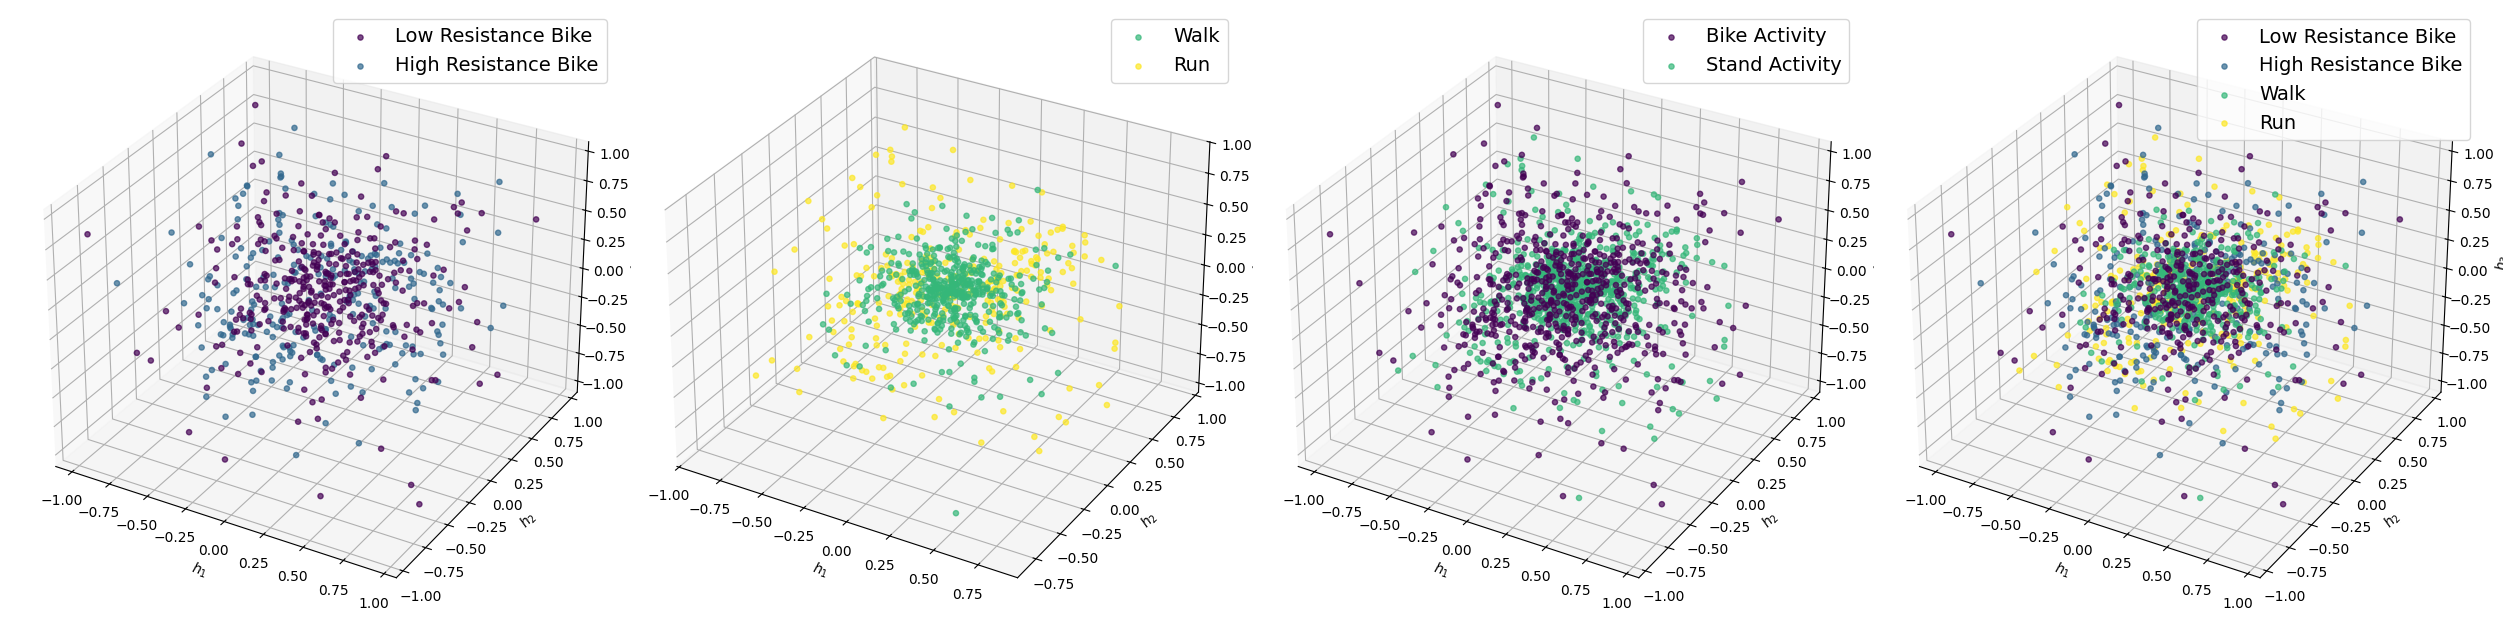

FCNN


/tmp/ipykernel_1936639/3828305997.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(label_map))


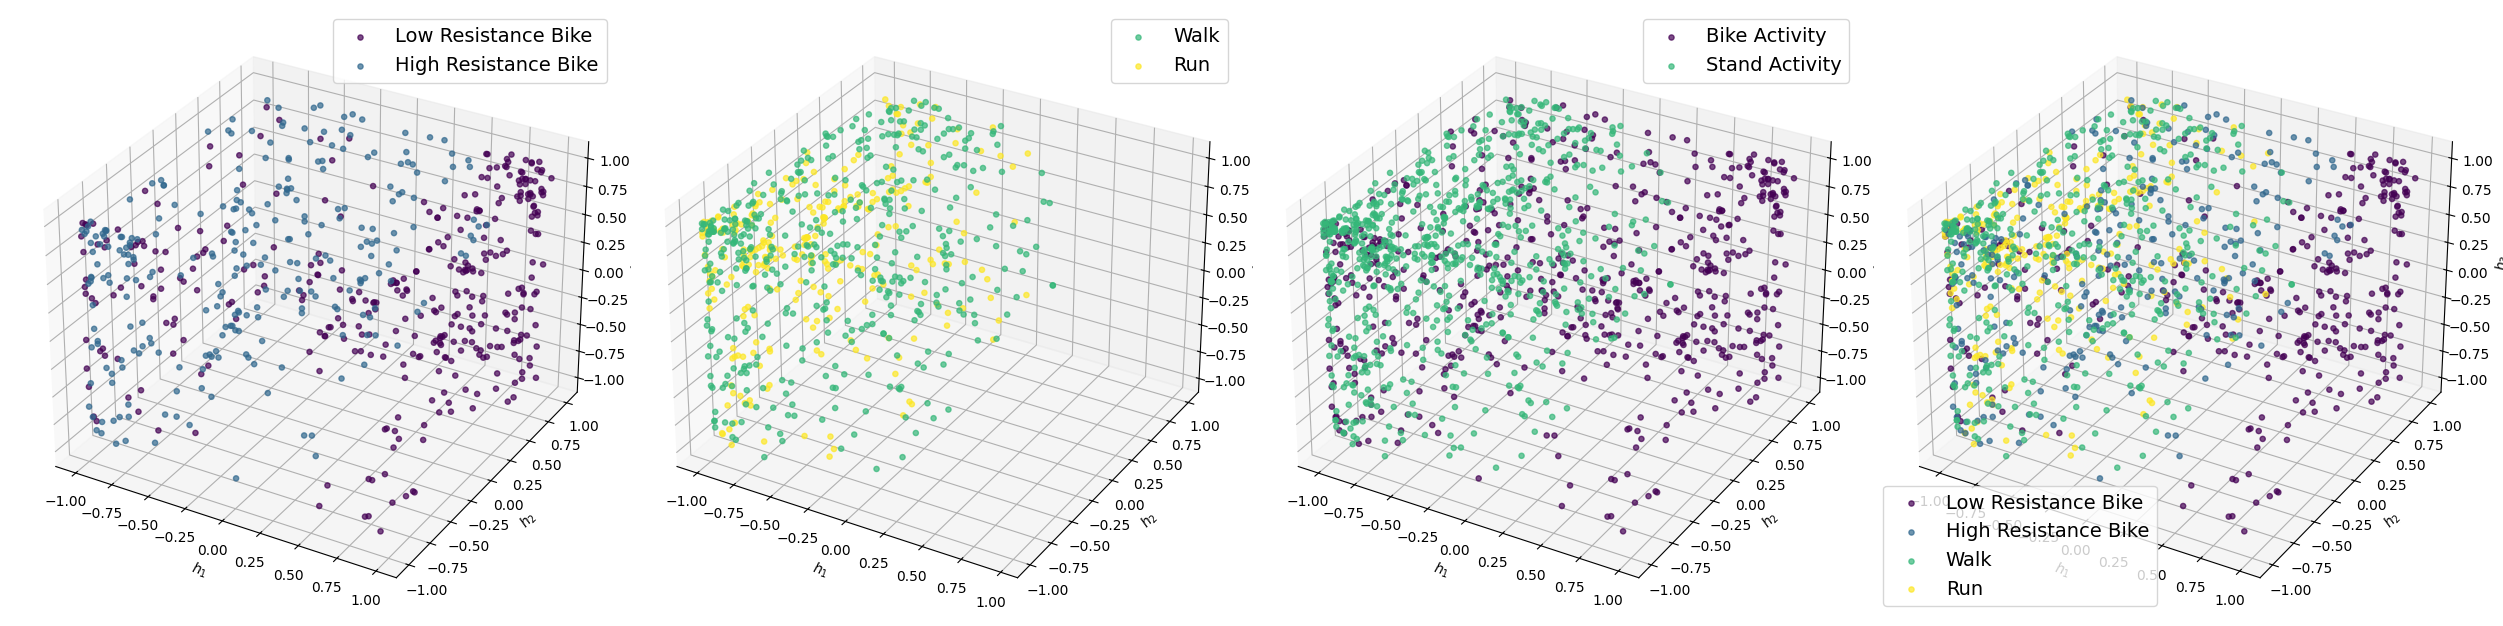

UMAP


/tmp/ipykernel_1936639/3828305997.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(label_map))


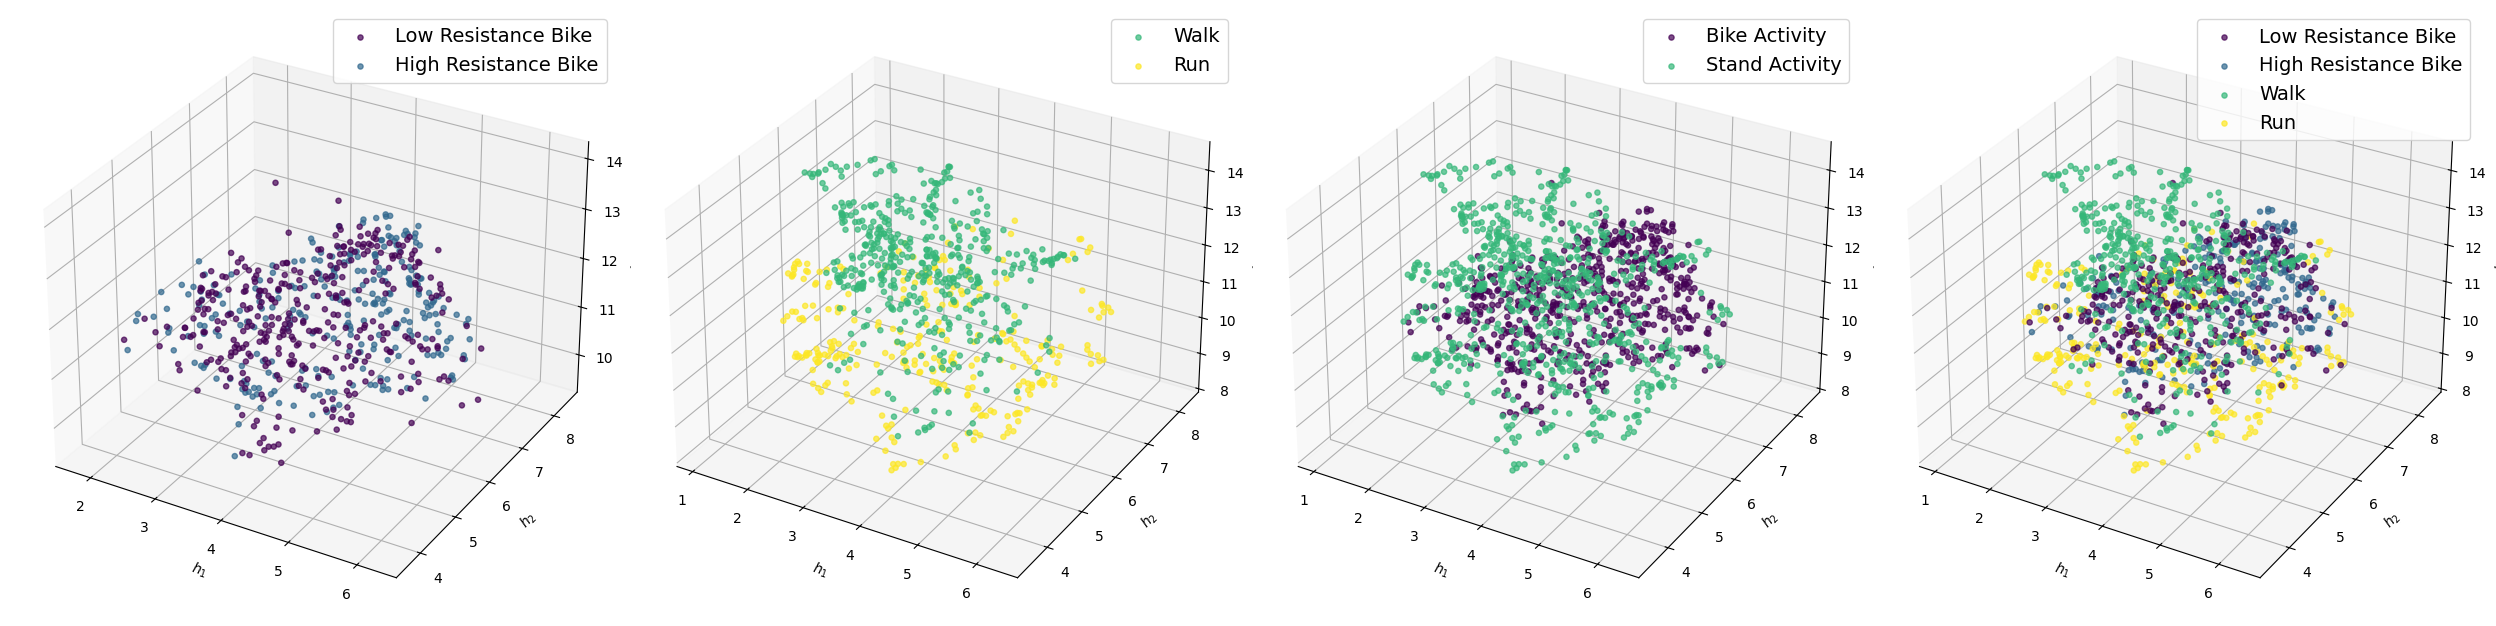

In [ ]:
# =============================================================================
# Section: Visualization of AE, FCNN, and UMAP Embeddings for Wrist PPG Data
# =============================================================================

print("Autoencoder")
plot_wrist_PPG(Htr_AE, Ytr, p=[1, 1], name='AE')

print("FCNN")
plot_wrist_PPG(Htr_FCNN, Ytr, p=[1, 1], name='FCNN')

print("UMAP")
plot_wrist_PPG(Htr_umap, Ytr, p=[1, 1], name='UMAP')
